In [1]:
# Copyright (c) 2024 Microsoft Corporation.
# Licensed under the MIT License

### with_nltk
#### init csv file

In [2]:
# our fake dataset
import asyncio
from pathlib import Path
import pandas as pd
import os
from graphrag.index.config import PipelineCSVInputConfig
from graphrag.index.input import load_input
init_dataset = pd.DataFrame([{"author": "aufsnn", 
                         "message": "Apple Inc. is an American multinational technology company headquartered in Cupertino, California. Tim Cook is the CEO of Apple.",
                         "date(yyyyMMddHHmmss)": "20240709182511"
                        },
                        {"author": "dmeck", 
                         "message": "hello!", 
                         "date(yyyyMMddHHmmss)": "20240709182511"}])

sample_data_dir = os.path.join(
    Path().cwd(), "input/"
)
if not os.path.exists(sample_data_dir):
    os.makedirs(sample_data_dir)
init_dataset.to_csv(f'{sample_data_dir}/dataset.csv', index=False)
sample_data_dir

'/media/gpt4-pdf-chatbot-langchain/graphrag/examples_notebooks/7_entity_extraction/with_nltk/input/'

In [3]:

shared_dataset = await load_input(
        PipelineCSVInputConfig(
            file_pattern=".*\\.csv$",
            base_dir=sample_data_dir,
            source_column="author",
            text_column="message",
            timestamp_column="date(yyyyMMddHHmmss)",
            timestamp_format="%Y%m%d%H%M%S",
            title_column="message",
        ),
    )
# We're cheap, and this is an example, lets just do 10
dataset = shared_dataset.head(10)
dataset

,author,message,date(yyyyMMddHHmmss),id,source,text,title,timestamp,year,month,day,hour,minute,second
0,aufsnn,Apple Inc. is an American multinational techno...,20240709182511,a9c886cbbc2905f65301a9215514ed0b,aufsnn,Apple Inc. is an American multinational techno...,Apple Inc. is an American multinational techno...,2024-07-09 18:25:11,2024,7,9,18,25,11
1,dmeck,hello!,20240709182511,409342b4e5e4bae7204236f4bf214055,dmeck,hello!,hello!,2024-07-09 18:25:11,2024,7,9,18,25,11


In [4]:
# Copyright (c) 2024 Microsoft Corporation.
# Licensed under the MIT License
from graphrag.index.workflows import WorkflowDefinitions

custom_workflows: WorkflowDefinitions = {
    "entity_extraction": lambda config: [
        {
            "verb": "entity_extract",
            "args": {
                "column": "message",
                "id_column": "author",
                "async_mode": "asyncio",
                "strategy": config.get(
                    "strategy"
                ),
                "to": "entities",
                "graph_to": "entity_graph",
            },
        }
    ]
}


#### create pipeline workflows file

In [5]:
import pandas as pd

from pathlib import Path

PIPELINE_YAML = """
workflows:
  - name: "entity_extraction"
    config:  
        strategy:
          type: "nltk" 
 
"""
pipeline_file =  Path().cwd() / "pipeline.yaml"
with pipeline_file.open("w") as file:
    file.write(PIPELINE_YAML)
    

In [6]:
# Load your config without the input section
config_path = str(pipeline_file)
config_path

'/media/gpt4-pdf-chatbot-langchain/graphrag/examples_notebooks/7_entity_extraction/with_nltk/pipeline.yaml'

#### start pipeline entity_extraction workflow

In [7]:

from graphrag.index import run_pipeline_with_config
# Grab the last result from the pipeline, should be our entity extraction
tables = []
async for table in run_pipeline_with_config(
    config_or_path=config_path, dataset=dataset, additional_workflows=custom_workflows
):
    tables.append(table)
pipeline_result = tables[-1]

# Print the entities.  This will be a row for each text unit, each with a list of entities
if pipeline_result.result is not None:
    print(pipeline_result.result["entities"].to_list())
else:
    print("No results!")


[nltk_data] Downloading package punkt to /home/dmeck/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/dmeck/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/dmeck/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/dmeck/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dmeck/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[[{'type': 'person', 'name': 'APPLE'}, {'type': 'organization', 'name': 'INC.'}, {'type': 'person', 'name': 'TIM COOK'}, {'type': 'organization', 'name': 'CEO'}], []]


#### use Python API flow pipeline 

In [8]:
from graphrag.index.config import PipelineWorkflowReference

workflows: list[PipelineWorkflowReference] = [
    PipelineWorkflowReference(
        name="entity_extraction",
        config={"strategy": {"type": "nltk"}},
    )
]


##### Run the pipeline

In [9]:
from graphrag.index import run_pipeline
# Grab the last result from the pipeline, should be our entity extraction
tables = []
async for table in run_pipeline(dataset=dataset, workflows=workflows, additional_workflows=custom_workflows):
    tables.append(table)
pipeline_result = tables[-1]

# Print the entities.  This will be a row for each text unit, each with a list of entities
if pipeline_result.result is not None:
    print(pipeline_result.result["entities"].to_list())
else:
    print("No results!")


[[{'type': 'person', 'name': 'APPLE'}, {'type': 'organization', 'name': 'INC.'}, {'type': 'person', 'name': 'TIM COOK'}, {'type': 'organization', 'name': 'CEO'}], []]


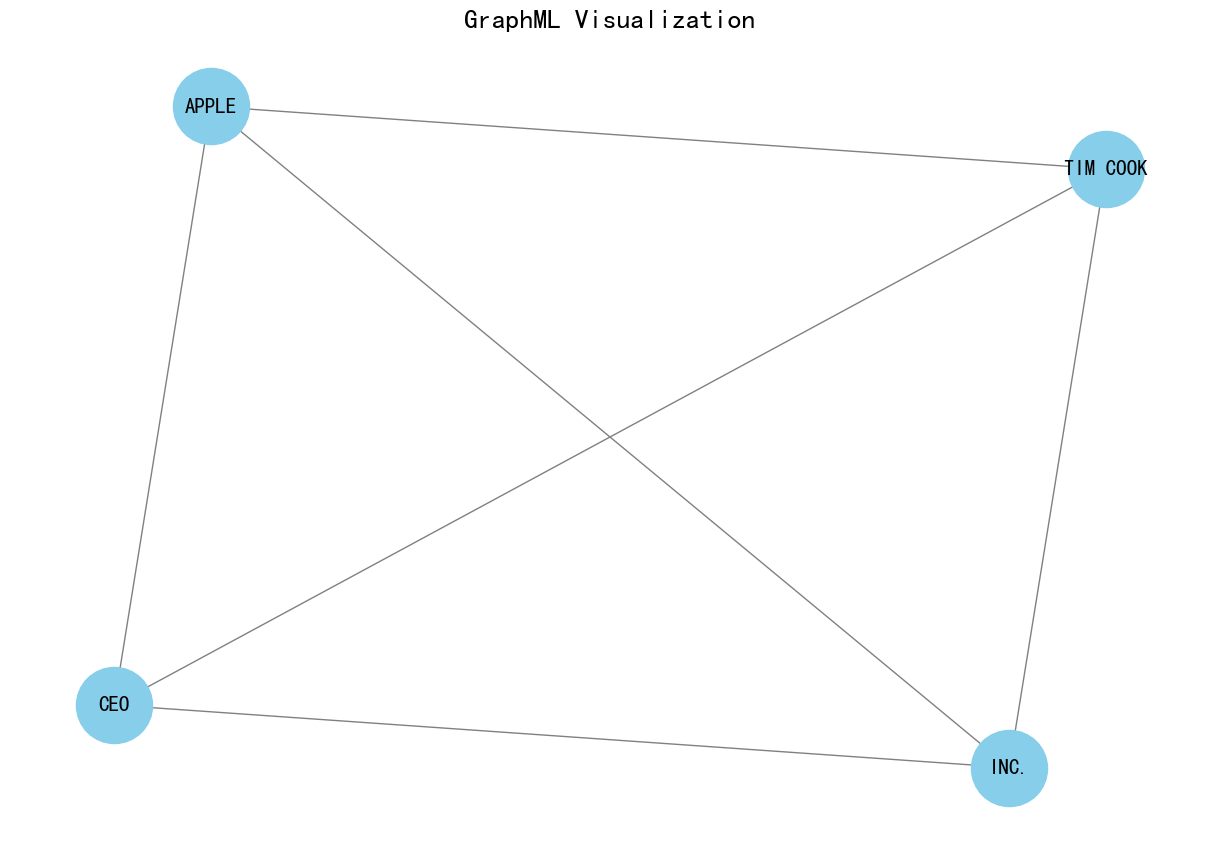

In [10]:
import matplotlib.pyplot as plt
from typing import Any, cast
import os
from pathlib import Path
import networkx as nx
import pandas as pd
from graphrag.index.utils import load_graph
from matplotlib import rcParams
import matplotlib.font_manager as fm

output_data_dir = os.path.join(
    Path().cwd(), "output/"
)

report_df = pd.read_parquet(f"{output_data_dir}/entity_extraction.parquet")

G = load_graph(cast(str | nx.Graph, report_df['entity_graph'][0]))

 # Set the font properties
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['SimHei']  # Use 'Noto Sans CJK' or another font that supports Chinese characters

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=3000, edge_color='gray', font_size=15, font_weight='bold')
plt.title('GraphML Visualization', size=20)
plt.show()
